# Ansatz with MPS

Here we document how to simulate the ansatz using **MPS** and the different functions implemented in the library. 

First we provide some basic MPS naming:

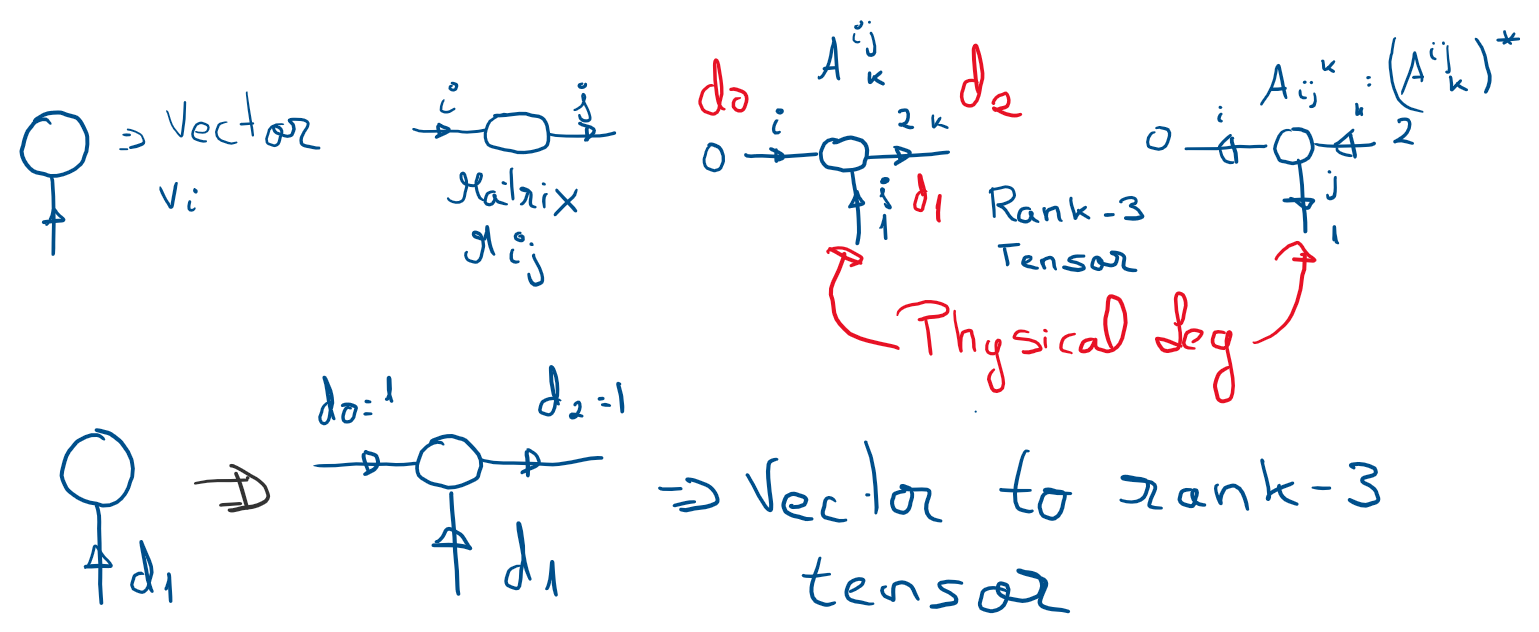

In [ ]:
import logging
logging.basicConfig(
    format='%(asctime)s-%(levelname)s: %(message)s',
    datefmt='%m/%d/%Y %I:%M:%S %p',
    level=logging.INFO
    #level=logging.DEBUG
)
logger = logging.getLogger('__name__')

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
import sys
sys.path.append("../")

In [ ]:
# myQLM qpus
from qat.qpus import PyLinalg, CLinalg
qpu_c = CLinalg()
qpu_p = PyLinalg()

## 1.Building Ansatz using MPS

First thing we need to do is simulate the ansatz circuit using **MPS**. In the following figure we show a layer of the ansatz circuit:

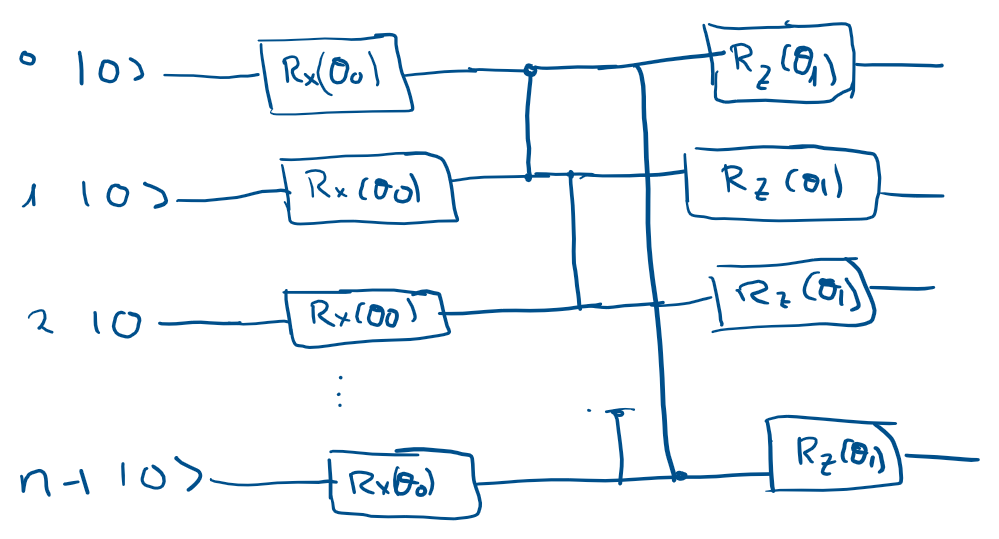

### 1.1 Initial state
For the beggining $|0\rangle$ states the MPS representation is given by:

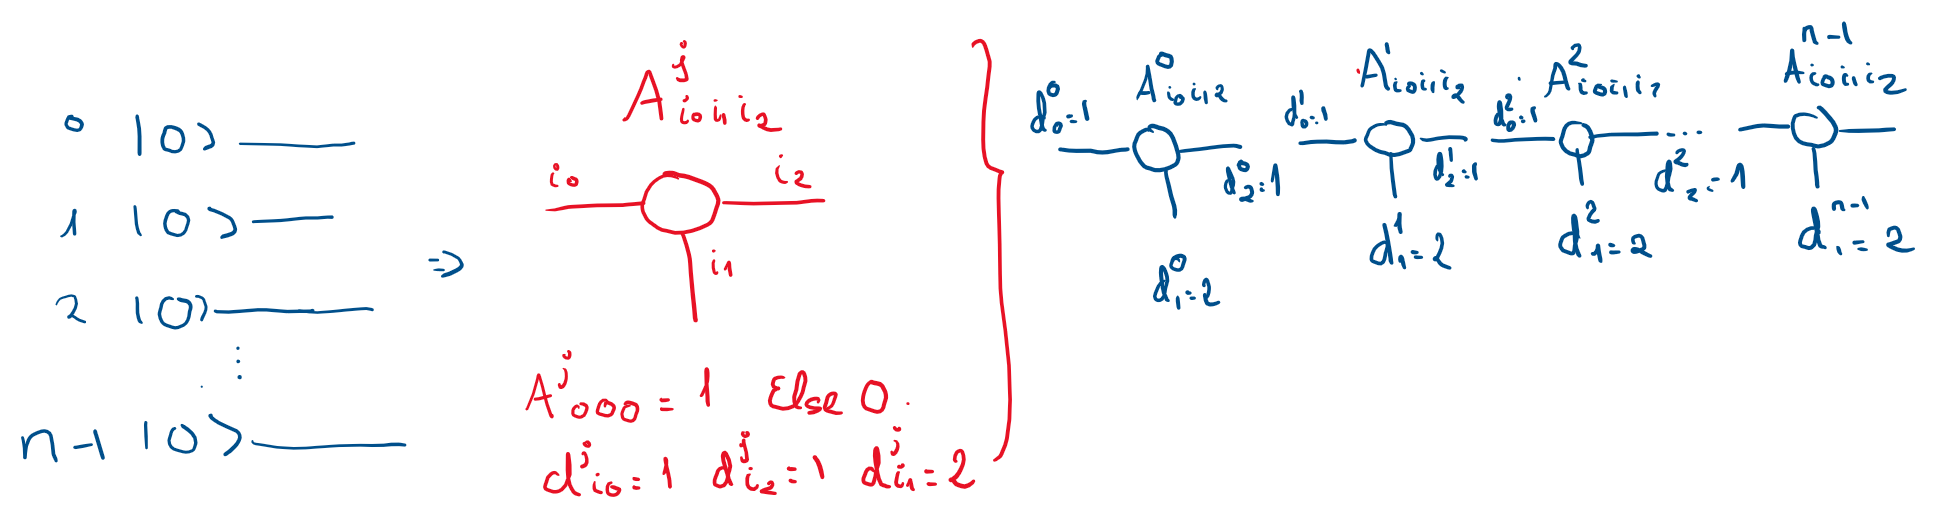

In [ ]:
# Initial state 
nqubits = 4
zeroket = np.zeros((1, 2, 1))
zeroket[0][0][0] = 1
zeroket = zeroket.astype(complex)
#Initial State
qubits_0 = [zeroket] * nqubits

In [ ]:
# Initila MPS state
[mps.shape for mps in qubits_0]

### 1.2 Apply local gates

The firs step is apply a local gate. In this case the operation is trivial as can be seen in the Figure:

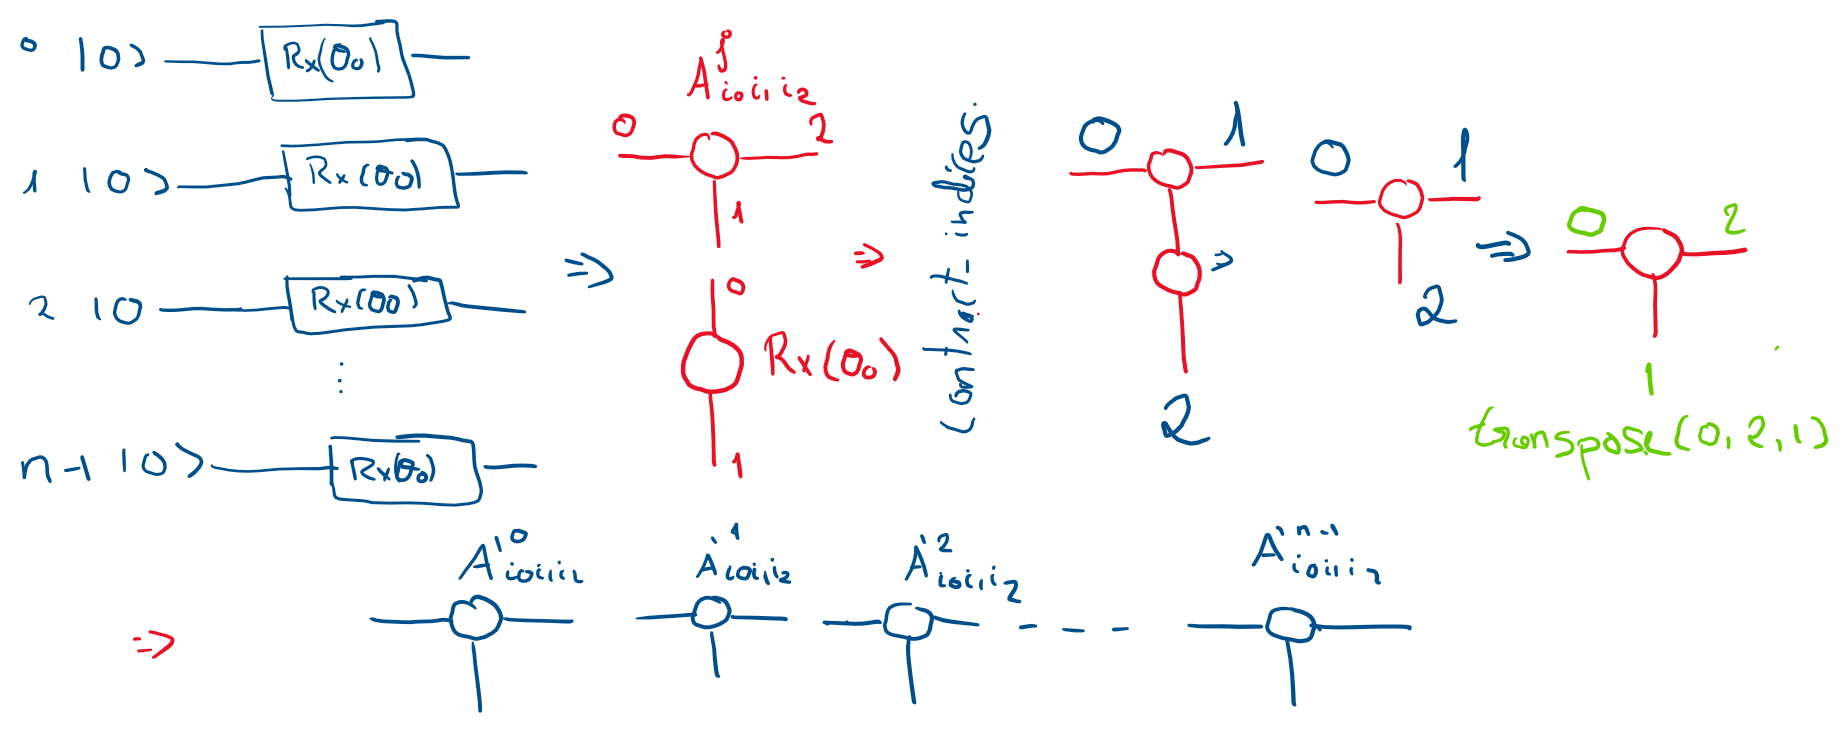



In [ ]:
from gates_mps import x_rotation
from contractions import contract_indices

We need to use the function *contract_indices* from **contractions** package for doing the contraction between the $|0\rangle$ state and the local gate (in this case a $R_x$). This function contracts two input tensors by the index provided. Following figure shows how to execute the contraction operation:

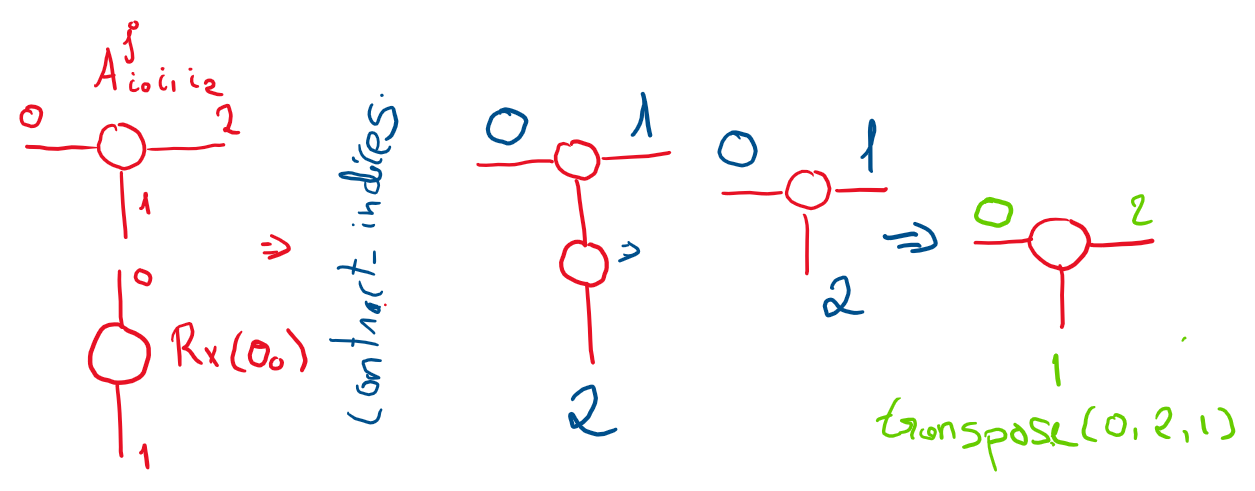

The resulting tensor will have the order convention showed in the middle pictures (the rule for oredering is: first the free indices of the first tensor and then free indices of the second one). So in order to keep our index convention we need to execute a transposition of the indices as showed in the Figure.


In [ ]:
tensor_out = contract_indices(qubits_0[0], x_rotation(np.pi /4.0), [1], [0])
tensor_out = tensor_out.transpose(0, 2, 1)

We need to apply the same gate over all the rank-3 tensor of the MPS. In this case we can use the function *apply_local_gate* from **mps** package. The first input is the list with the **MPS** and the second one is a list where each element is the local gate that should be applied over each element of the **MPS**. If you don't want a gate over a fixed qubit (or qubits) only send  a **None**.

In [ ]:
from mps import apply_local_gate

In [ ]:
gates = [x_rotation(np.pi /4.0) for i in qubits_0]

In [ ]:
firs_rotations = apply_local_gate(qubits_0, gates)

The function *compose_mps* from **mps** package allows to compute the final state of a input mps

In [ ]:
from mps import compose_mps

In [ ]:
state = compose_mps(firs_rotations)
state = state.reshape(2**nqubits)

Following cell implement same circuit in **Eviden myQLM** and test if **MPS** computations were donde properly

In [ ]:
import qat.lang.AQASM as qlm
from qat.qpus import CLinalg
from ansatzes import proccess_qresults
def do_staff(nqubits, qpu_c=CLinalg()):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.RX(np.pi /4.0), qbits[i])
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_c.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   
pdf, circ = do_staff(nqubits)

In [ ]:
print("Test: {}".format(np.isclose(np.array(pdf["Amplitude"]), state).all()))

### 1.3 Apply two qubits gates.

The second step of the ansatz circuit is a circular waterfall of Controlled-Z gates.


#### General Non-Local Gate MPS simulation

Given two generic rank-3 tensors that represent 2 qubits: $A_{ijk}$, with dimensions:  $(d^A_0, d^A_1, d^A_2)$,  and $B_{ijk}$, with dimensions:  $(d^B_0, d^B_1, d^B_2)$, such that their **physical legs** has dimension 2 ($d^A_1=d^B_1=2$), and **non-local gate** that act between these 2 qubits ($d^{gate}_0 = d^{gate}_1 = 4$), the workflow for simulating the **non-local gate** using MPS is the following

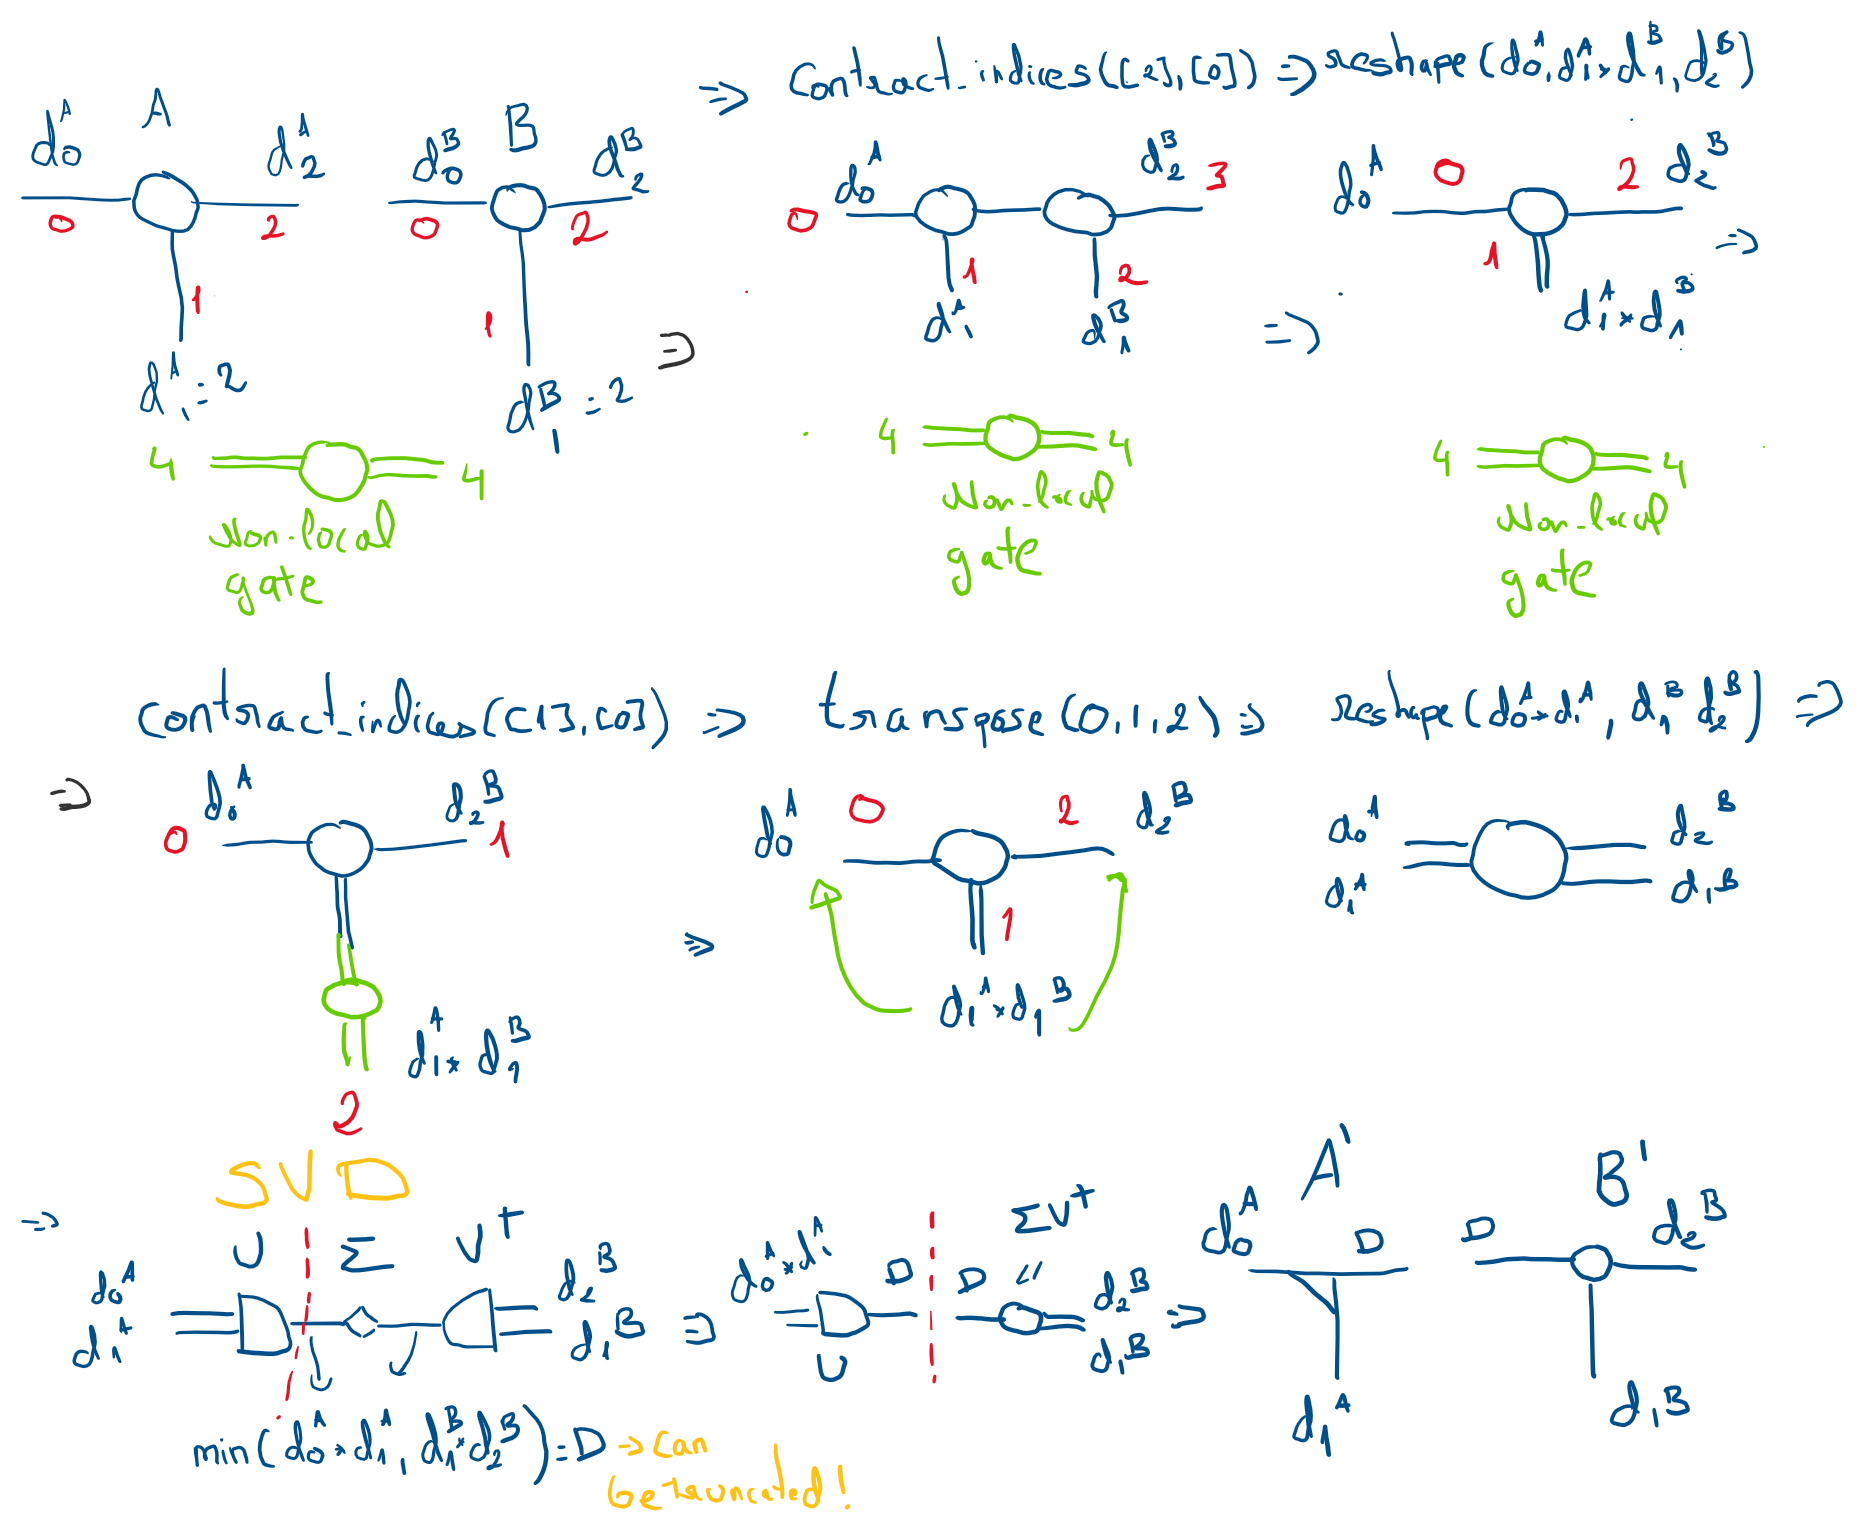

This complete workflow can be executed by using the function *apply_2qubit_gate* from **mps** package. The inputs are:

* tensor_1: first tensor
* tensor_2 : second tensor
* gate : numpy array representing the **non-local** gate.
* truncate: Boolean value for truncating the **SVD** (orange text in Figure).
* t_v : float for doing the truncation of the SVD. Only valid if *truncate=True*. Diagonal elements higher than t_v are kept. If *truncate=True* and *t_v=None* the cut-off will be the precision of the numpy float (so only we will keep the non-zero values up to float precision)

In [ ]:
from mps import apply_2qubit_gate
# Our non local gate
from gates_mps import controlz

In [ ]:
tensor_left, tensor_right = apply_2qubit_gate(
    firs_rotations[0], firs_rotations[1], controlz())

In [ ]:
tensor_left.shape, tensor_right.shape

In [ ]:
t1 = np.random.random((10, 2, 4))
t2 = np.random.random((4, 2, 8))

In [ ]:
#No Truncation
tensor_left, tensor_right = apply_2qubit_gate(t1, t2, controlz())
print(tensor_left.shape, tensor_right.shape)

In [ ]:
# Truncation by zero
tensor_left, tensor_right = apply_2qubit_gate(t1, t2, controlz(), truncate=True)
print(tensor_left.shape, tensor_right.shape)

In [ ]:
# Truncation by 0.01
tensor_left, tensor_right = apply_2qubit_gate(
    t1, t2, controlz(), truncate=True, t_v=0.01)
print(tensor_left.shape, tensor_right.shape)

#### Workflow of circular waterfall of Controlled-gates

For simulating the complete circular waterfall of controlled-Z gates the following graphical schemed is followed:

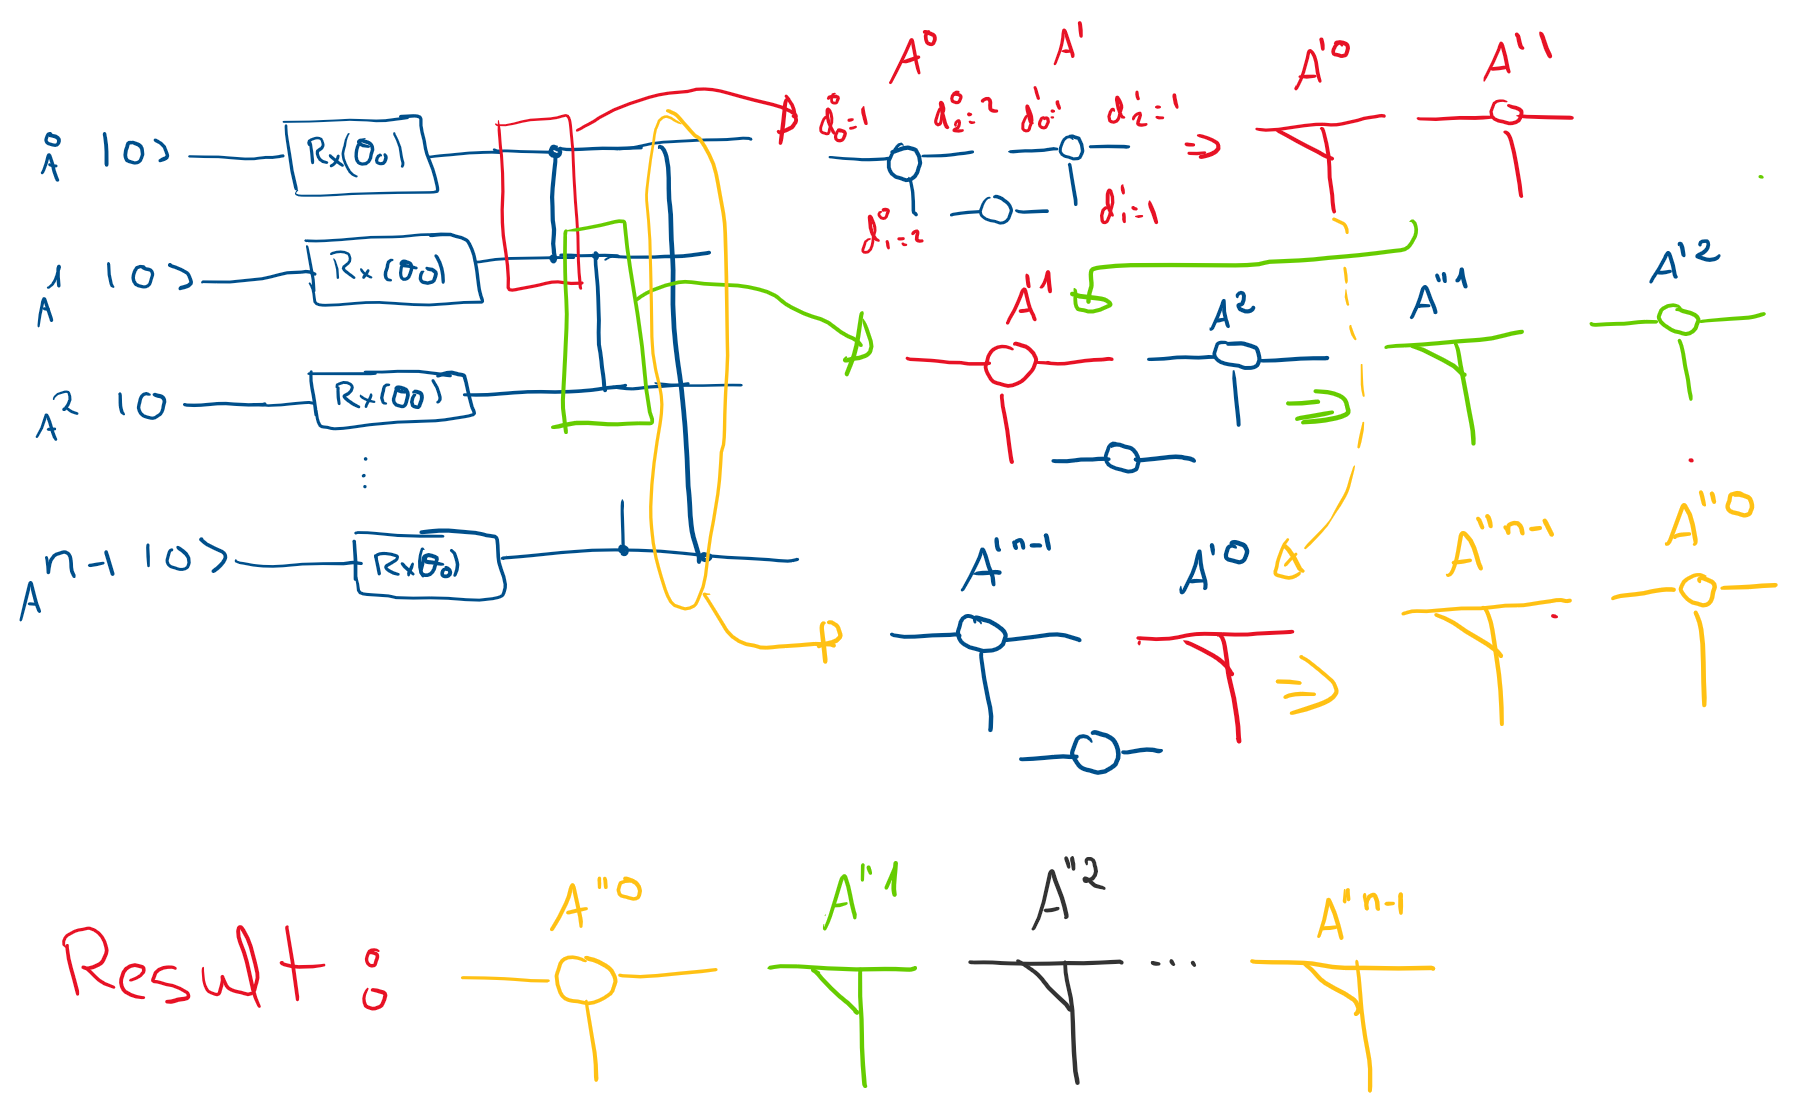

This workflow is executed by the *apply_2qubit_gates* (**BE AWARE of the final s!!**) from **mps** package. The function takes as input the **MPS** list, a list with all the **non-local** gates appplied and needs the *truncate* and the *t_v* arguments if truncation-SVD is desired!

In [ ]:
from mps import apply_2qubit_gates

In [ ]:
non_local_gates = [controlz() for i in firs_rotations]
controlled_waterfall = apply_2qubit_gates(firs_rotations, non_local_gates)

Finally we can compose all the MPS for getting the final state. In this case we need to contract the right leg of the last qubit with the left leg of the first qubit because the implemented ansatz is translational invari

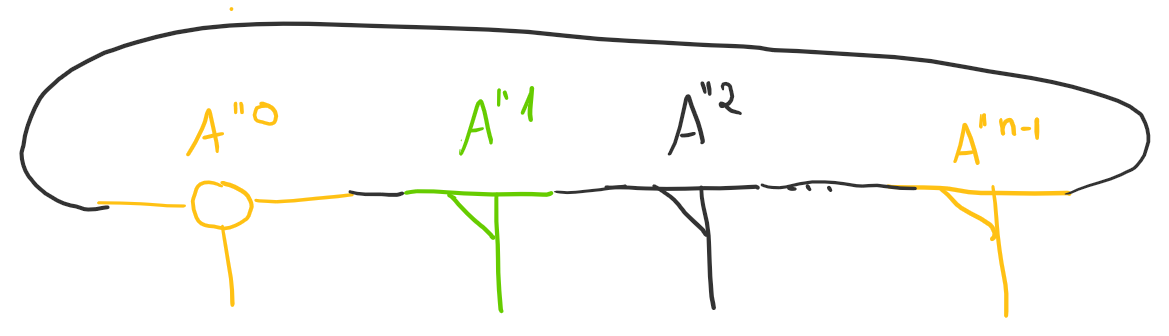

In [ ]:
from mps import contract_indices_one_tensor

In [ ]:
state_nonlocal = compose_mps(controlled_waterfall)
print(state_nonlocal.shape)
state_nonlocal = contract_indices_one_tensor(
    state_nonlocal, [(0, state_nonlocal.ndim-1)])

state_nonlocal = state_nonlocal.reshape(2**nqubits)

Now we can compare the resulting state of the mps with the same *Eviden myQLM* circuit

In [ ]:
def do_staff_nonlocal(nqubits, qpu_c=CLinalg()):
    qprog = qlm.Program()
    qbits = qprog.qalloc(nqubits)
    for i in range(nqubits):
        qprog.apply(qlm.RX(np.pi /4.0), qbits[i])
    for i in range(nqubits-1):
        qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])    
    qprog.apply(qlm.Z.ctrl(), qbits[nqubits-1], qbits[0])        
    circ = qprog.to_circ()
    #%qatdisplay circ
    job = circ.to_job()
    state = qpu_c.submit(job)
    pdf = proccess_qresults(state, nqubits)
    pdf.reset_index(drop=True, inplace=True)
    return pdf, circ   
pdf_nonlocal, circ = do_staff_nonlocal(nqubits)

In [ ]:
Test = np.isclose(pdf_nonlocal["Amplitude"], state_nonlocal).all()
print("Test correct: {}".format(Test))

**NOTE**

The ansatz for the **BTC** is trnaslational invariant so it is mandatory that the last qubit controls the first one giving place to a boundary condition. In this case the number of **non-local** gates is equal to the number of qubis.

For other type of circuits this boundary condition does no exist. In this case we can set the last element of **non-local** gates list to **None**.

### 1.4 Apply second group of local gates.

Now we need to apply a group of $R_z$ gates. This can be done in an easy way using the function *apply_local_gate*, as explained before, and creating a list with the corresponding gate (*z_rotation* from **gates_mps**)

## 2. ansatz_mps  function

In order to simplify the procces the *ansatz_mps* from **ansatz_mps** packages was created. This function needs following inputs:

* nqubits: number qbits for the ansazt
* depth : depth of the ansatz
* angles: list with the angles for the ansatz
* truncate : Bool for truncating or not the SVDs
* t_v : Cutt-off for the SVD truncation

Additionally the function *get_angles* compute the angles following the **BTC** recomendations

In [ ]:
from  ansatz_mps import ansatz_mps, get_angles

In [ ]:
truncate = True
t_v = None
depth = 4
angles = get_angles(depth)
mps = ansatz_mps(nqubits, depth, angles, truncate, t_v)
tensor = compose_mps(mps)
state = contract_indices_one_tensor(tensor, [(0, tensor.ndim-1)])
state = state.reshape(np.prod(state.shape))
pdf_mps = pd.DataFrame(state, columns=["Amplitude"])
state_name = ["|" + bin(i)[2:].zfill(nqubits) + ">" for i in range(2**nqubits)]
pdf_mps["state"] = state_name

We can compare the result with anstaz from *Eviden myQLM* simulation

In [ ]:
from ansatzes import run_ansatz

In [ ]:
ansatz_dict = {
    "nqubits" : nqubits,
    "depth": depth,
    "ansatz": "simple01",
    "qpu_ansatz": "c",
    "save" : False,
    "folder" : ""
}

In [ ]:
output = run_ansatz(**ansatz_dict)

In [ ]:
pdf_myQLM = output["state"]

In [ ]:
Test = np.isclose(pdf_myQLM["Amplitude"], pdf_mps["Amplitude"]).all()
print("Test: {}".format(Test))